In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt


In [2]:
# Veri artırma işlemleri
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

Root_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = Root_dir + "/train"
valid_dir = Root_dir + "/valid"
test_dir = "/kaggle/input/new-plant-diseases-dataset/test"
Diseases_classes = os.listdir(train_dir)


# Veri yükleme
batch_size = 32
img_size = (224, 224)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Found 33 images belonging to 1 classes.


In [3]:
# Sınıf ağırlıkları hesaplama
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))


In [5]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import VGG16


# ResNet50 modelinin yüklenmesi
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
# Üst katmanların eklenmesi
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)  # Dropout ekleme
dense_output = Dense(len(Diseases_classes), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=dense_output)

#x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Modelin oluşturulması
#model = Model(inputs=base_model.input, outputs=predictions)

# Bazı katmanları dondur
#for layer in base_model.layers[:140]:  # İlk 140 katmanı dondur
#    layer.trainable = False
#for layer in base_model.layers[140:]:  # Sonraki katmanları eğitilebilir yap
#    layer.trainable = True


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Modelin derlenmesi
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
#model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Derleme
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
# Callbacks
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#checkpoint = ModelCheckpoint('best_resnet50_model.keras', monitor='val_loss', save_best_only=True)

from tensorflow.keras.callbacks import ReduceLROnPlateau

# Callback'ler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')


In [8]:
# Model eğitimi
#history = model.fit(
    #train_generator,
    #epochs=10,
   # validation_data=valid_generator,
  #  class_weight=class_weights_dict,
 #   callbacks=[early_stopping, checkpoint]
#)



# Model eğitimi
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)




# Fine-Tuning (Bazı katmanları serbest bırakma)
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734196109.311179     116 service.cc:145] XLA service 0x7b884400ea60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734196109.311236     116 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734196109.311240     116 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   1/2197 ━━━━━━━━━━━━━━━━━━━━ 12:40:27 21s/step - accuracy: 0.0000e+00 - loss: 4.0609

I0000 00:00:1734196124.557793     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1352s 606ms/step - accuracy: 0.2860 - loss: 2.8707 - val_accuracy: 0.7260 - val_loss: 1.4117 - learning_rate: 0.0010
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 943s 428ms/step - accuracy: 0.5772 - loss: 1.6341 - val_accuracy: 0.7679 - val_loss: 1.0418 - learning_rate: 0.0010
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 930s 422ms/step - accuracy: 0.6170 - loss: 1.3824 - val_accuracy: 0.7914 - val_loss: 0.8776 - learning_rate: 0.0010
Epoch 4/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 905s 411ms/step - accuracy: 0.6338 - loss: 1.2702 - val_accuracy: 0.8062 - val_loss: 0.7963 - learning_rate: 0.0010
Epoch 5/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 901s 409ms/step - accuracy: 0.6528 - loss: 1.1965 - val_accuracy: 0.8100 - val_loss: 0.7441 - learning_rate: 0.0010
Epoch 6/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 908s 412ms/step - accuracy: 0.6614 - loss: 1.1440 - val_accuracy: 0.8177 - val_loss: 0.7032 - learning_rate: 0.0010
Epoch 7/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 903s 410ms/step - ac

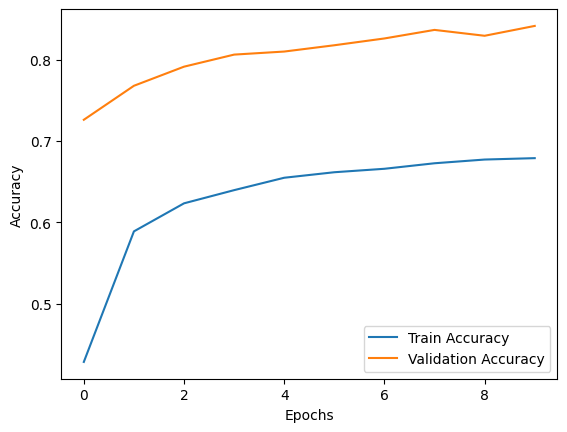

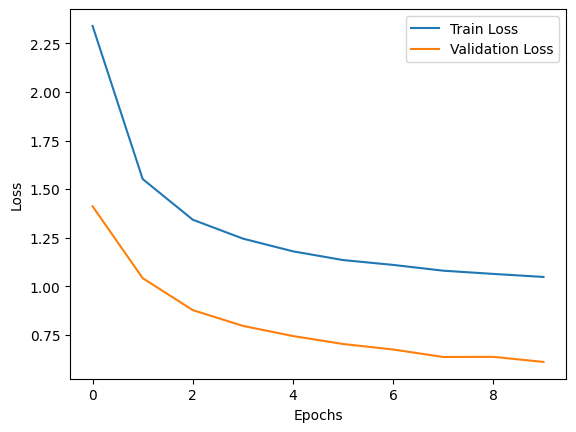

In [9]:
# Eğitim ve doğrulama doğruluğunu görselleştirme
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Eğitim ve doğrulama kaybını görselleştirme
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [10]:
# Test setinde değerlendirme
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.0919 - loss: 1796.5074 
Test Accuracy: 9.09%


In [11]:
# Modeli kaydetme
model.save('resnet50_final_model.h5')


In [12]:
# Kaydedilen modeli yükleme
from tensorflow.keras.models import load_model
loaded_model = load_model('resnet50_final_model.h5')


In [13]:
labels = []
predictions = []
for x,y in test_gen:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())

NameError: name 'test_gen' is not defined

In [1]:
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

NameError: name 'itertools' is not defined

In [2]:
print("Train Accuracy  : {:.2f} %".format(history.history['accuracy'][-1]*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))

NameError: name 'history' is not defined

In [3]:
plt.figure(figsize= (20,5))
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(1,39)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
model_saved =  tf.keras.models.load_model('model.h5')

In [ ]:
model_saved.summary()

In [ ]:
#model_saved()